<a href="https://colab.research.google.com/github/sourcecode369/TensorFlow-2.0/blob/master/tensorflow_2.0_docs/TensorFlow%20Core/Tutorials/Structured%20Data/Imbalanced%20Data%20Classification/Classification_on_Imbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.0.0)


### Importing the Dependencies

In [97]:
%%time
%reload_ext tensorboard
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
print("TensorFlow is executing eagerly.",tf.executing_eagerly())
print("TensorFlow version: ",tf.__version__)
tf.random.set_seed(1)
if tf.config.experimental.list_physical_devices("GPU"):
    print("GPU is available.")
try:
    %tensorflow_version 2.x
except:
    print("TensorFlow 2.0 is not loaded.")
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.datasets import *

import os
os.environ["PYTHONHASHSEED"] = str(1)
import gc
gc.enable()

import numpy as np
np.set_printoptions(precision=2)
np.random.seed(1)
import pandas as pd
pd.option_context("display.max_rows",100)
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = "retina"
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set(rc={"figure.figsize":(12,10)})

import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import sklearn
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.feature_selection import * 
from sklearn.feature_extraction import *
from sklearn.preprocessing import *

TensorFlow is executing eagerly. True
TensorFlow version:  2.0.0
TensorFlow is already loaded. Please restart the runtime to change versions.
CPU times: user 117 ms, sys: 22.9 ms, total: 140 ms
Wall time: 144 ms


### Data Collection

In [98]:
file = tf.keras.utils
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Data Exploration

In [99]:
df.isnull().sum().sort_index()/len(df)

Amount    0.0
Class     0.0
Time      0.0
V1        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V2        0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
dtype: float64

In [100]:
df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V26,284807.0,1.699104e-15,0.482227,-2.604551,-0.326984,-0.052139,0.240952,3.517346
V27,284807.0,-3.660161e-16,0.403632,-22.565679,-0.070840,0.001342,0.091045,31.612198
V28,284807.0,-1.206049e-16,0.330083,-15.430084,-0.052960,0.011244,0.078280,33.847808
Amount,284807.0,8.834962e+01,250.120109,0.000000,5.600000,22.000000,77.165000,25691.160000


### Data Preprocessing

In [101]:
neg, pos = np.bincount(df["Class"])
total = neg + pos
print(f"Examples:\n Total: {total}\n  Postive: {pos} {np.round(100*pos/total,3)}")

Examples:
 Total: 284807
  Postive: 492 0.173


In [0]:
cleaned_df = df.copy()
cleaned_df.pop("Time")
eps = 0.001
cleaned_df["Log Amount"] = np.log(cleaned_df.pop("Amount")+eps)

In [0]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(cleaned_df, test_size=0.2)

train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [104]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print("Training labels", train_labels.shape)
print("Validation labels", val_labels.shape)
print("Test labels", test_labels.shape)

print("Training features", train_features.shape)
print("Validation features", val_features.shape)
print("Test features", test_features.shape)

Training labels (227845,)
Validation labels (56962,)
Test labels (56962,)
Training features (227845, 29)
Validation features (56962, 29)
Test features (56962, 29)


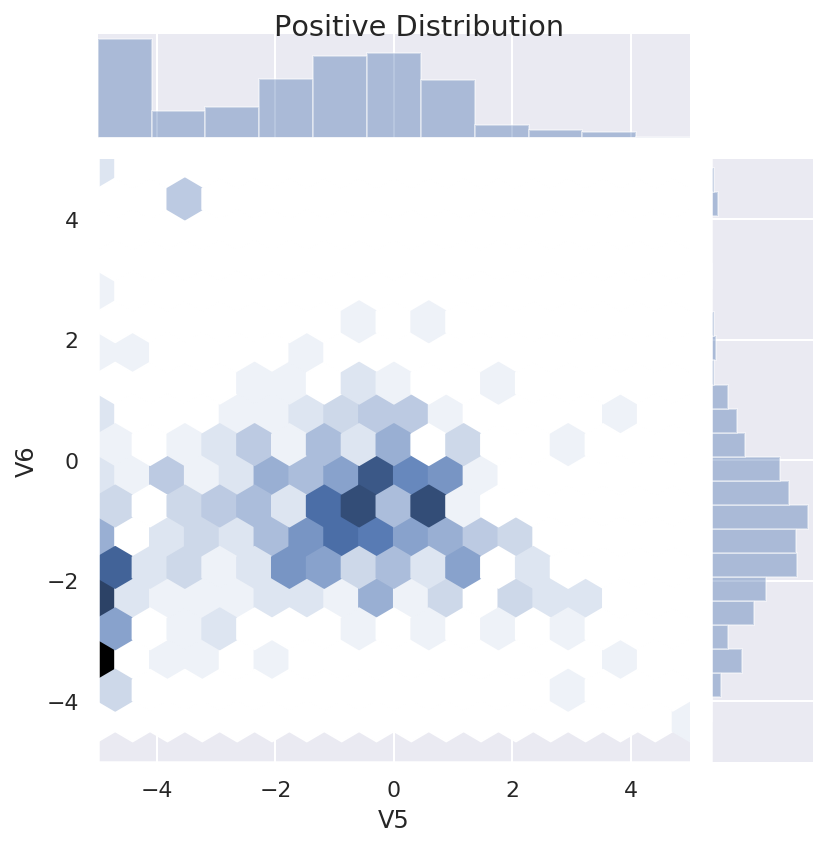

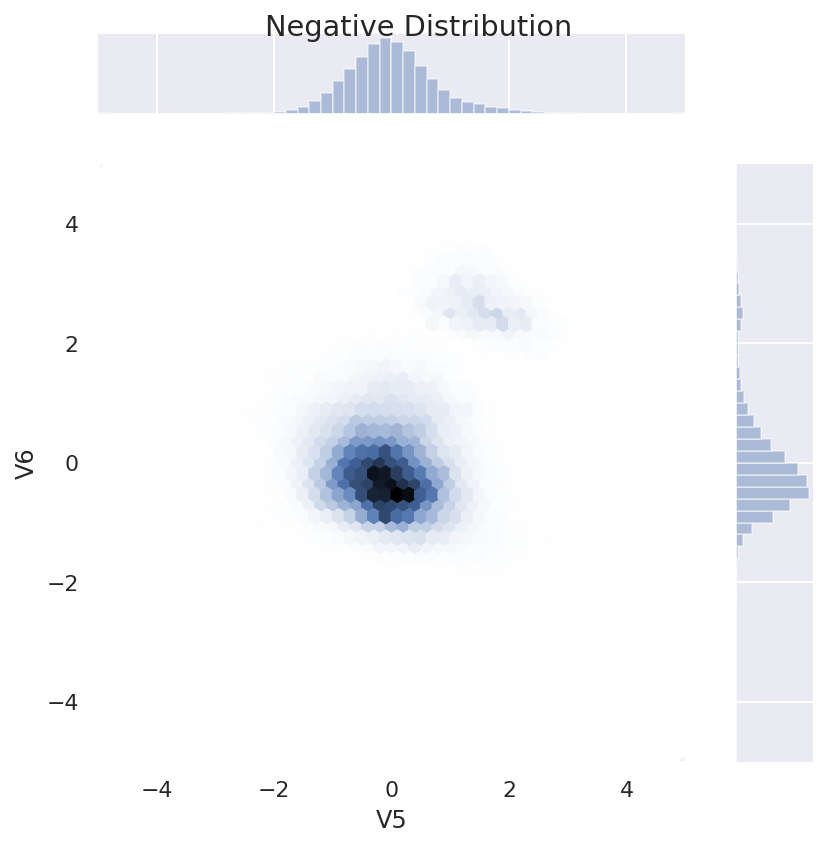

In [105]:
pos_df = pd.DataFrame(train_features[bool_train_labels],columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels],columns=train_df.columns)

sns.jointplot(pos_df["V5"],pos_df["V6"], kind="hex", xlim=(-5, 5), ylim=(-5,5))
plt.suptitle("Positive Distribution")

sns.jointplot(neg_df["V5"],neg_df["V6"], kind="hex", xlim=(-5,5),ylim=(-5,5))
plt.suptitle("Negative Distribution")
plt.tight_layout()

### Baseline Model

In [0]:
METRICS = [
           tf.keras.metrics.TruePositives(name="tp"),
           tf.keras.metrics.FalsePositives(name="fp"),
           tf.keras.metrics.TrueNegatives(name="tn"),
           tf.keras.metrics.FalseNegatives(name="fn"),
           tf.keras.metrics.BinaryAccuracy(name="accuracy"),
           tf.keras.metrics.Precision(name="precision"),
           tf.keras.metrics.Recall(name="recall"),
           tf.keras.metrics.AUC(name="auc")
]

In [0]:
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.Sequential([
                                 tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu,input_shape=(train_features.shape[-1],), kernel_initializer="he_uniform"),
                                 tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu, kernel_initializer="he_uniform"),
                                 tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, bias_initializer=output_bias)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
    return model

In [0]:
EPOCHS = 100
BATCH_SIZE = 2048
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_acc",
    verbose=1,
    patience=10,
    mode="max",
    restore_best_weights=True
)

In [109]:
model = make_model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 64)                1920      
_________________________________________________________________
dense_40 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 33        
Total params: 4,033
Trainable params: 4,033
Non-trainable params: 0
_________________________________________________________________


In [110]:
model.predict(train_features[:10])

array([[0.37],
       [0.42],
       [0.24],
       [0.35],
       [0.11],
       [0.53],
       [0.19],
       [0.18],
       [0.28],
       [0.4 ]], dtype=float32)

In [111]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4530


In [112]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.36])

In [113]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [114]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:.4f}".format(results[0]))

Loss: 0.0194


In [0]:
import tempfile
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [116]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features, 
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features,val_labels),
    verbose=2
)

Train on 227845 samples, validate on 56962 samples
Epoch 1/20
227845/227845 - 4s - loss: 0.1029 - tp: 35.0000 - fp: 6371.0000 - tn: 221083.0000 - fn: 356.0000 - accuracy: 0.9705 - precision: 0.0055 - recall: 0.0895 - auc: 0.4599 - val_loss: 0.0112 - val_tp: 47.0000 - val_fp: 6.0000 - val_tn: 56855.0000 - val_fn: 54.0000 - val_accuracy: 0.9989 - val_precision: 0.8868 - val_recall: 0.4653 - val_auc: 0.8886
Epoch 2/20
227845/227845 - 2s - loss: 0.0075 - tp: 271.0000 - fp: 40.0000 - tn: 227414.0000 - fn: 120.0000 - accuracy: 0.9993 - precision: 0.8714 - recall: 0.6931 - auc: 0.8973 - val_loss: 0.0057 - val_tp: 75.0000 - val_fp: 13.0000 - val_tn: 56848.0000 - val_fn: 26.0000 - val_accuracy: 0.9993 - val_precision: 0.8523 - val_recall: 0.7426 - val_auc: 0.8972
Epoch 3/20
227845/227845 - 2s - loss: 0.0049 - tp: 295.0000 - fp: 37.0000 - tn: 227417.0000 - fn: 96.0000 - accuracy: 0.9994 - precision: 0.8886 - recall: 0.7545 - auc: 0.9120 - val_loss: 0.0046 - val_tp: 76.0000 - val_fp: 15.0000 - va

In [117]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features, 
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features,val_labels),
    verbose=2
)

Train on 227845 samples, validate on 56962 samples
Epoch 1/20
227845/227845 - 4s - loss: 0.0051 - tp: 225.0000 - fp: 29.0000 - tn: 227425.0000 - fn: 166.0000 - accuracy: 0.9991 - precision: 0.8858 - recall: 0.5754 - auc: 0.8986 - val_loss: 0.0034 - val_tp: 77.0000 - val_fp: 9.0000 - val_tn: 56852.0000 - val_fn: 24.0000 - val_accuracy: 0.9994 - val_precision: 0.8953 - val_recall: 0.7624 - val_auc: 0.9201
Epoch 2/20
227845/227845 - 1s - loss: 0.0028 - tp: 299.0000 - fp: 36.0000 - tn: 227418.0000 - fn: 92.0000 - accuracy: 0.9994 - precision: 0.8925 - recall: 0.7647 - auc: 0.9419 - val_loss: 0.0034 - val_tp: 79.0000 - val_fp: 18.0000 - val_tn: 56843.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8144 - val_recall: 0.7822 - val_auc: 0.9155
Epoch 3/20
227845/227845 - 1s - loss: 0.0026 - tp: 300.0000 - fp: 33.0000 - tn: 227421.0000 - fn: 91.0000 - accuracy: 0.9995 - precision: 0.9009 - recall: 0.7673 - auc: 0.9445 - val_loss: 0.0035 - val_tp: 80.0000 - val_fp: 18.0000 - val_

In [0]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [0]:
def plot_loss(history,label, n):
    sns.set_style("whitegrid")
    plt.semilogy(history.epoch, history.history["loss"],color=colors[n],label="Train "+label)
    plt.semilogy(history.epoch, history.history["val_loss"], color=colors[n], label="Val "+label,linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

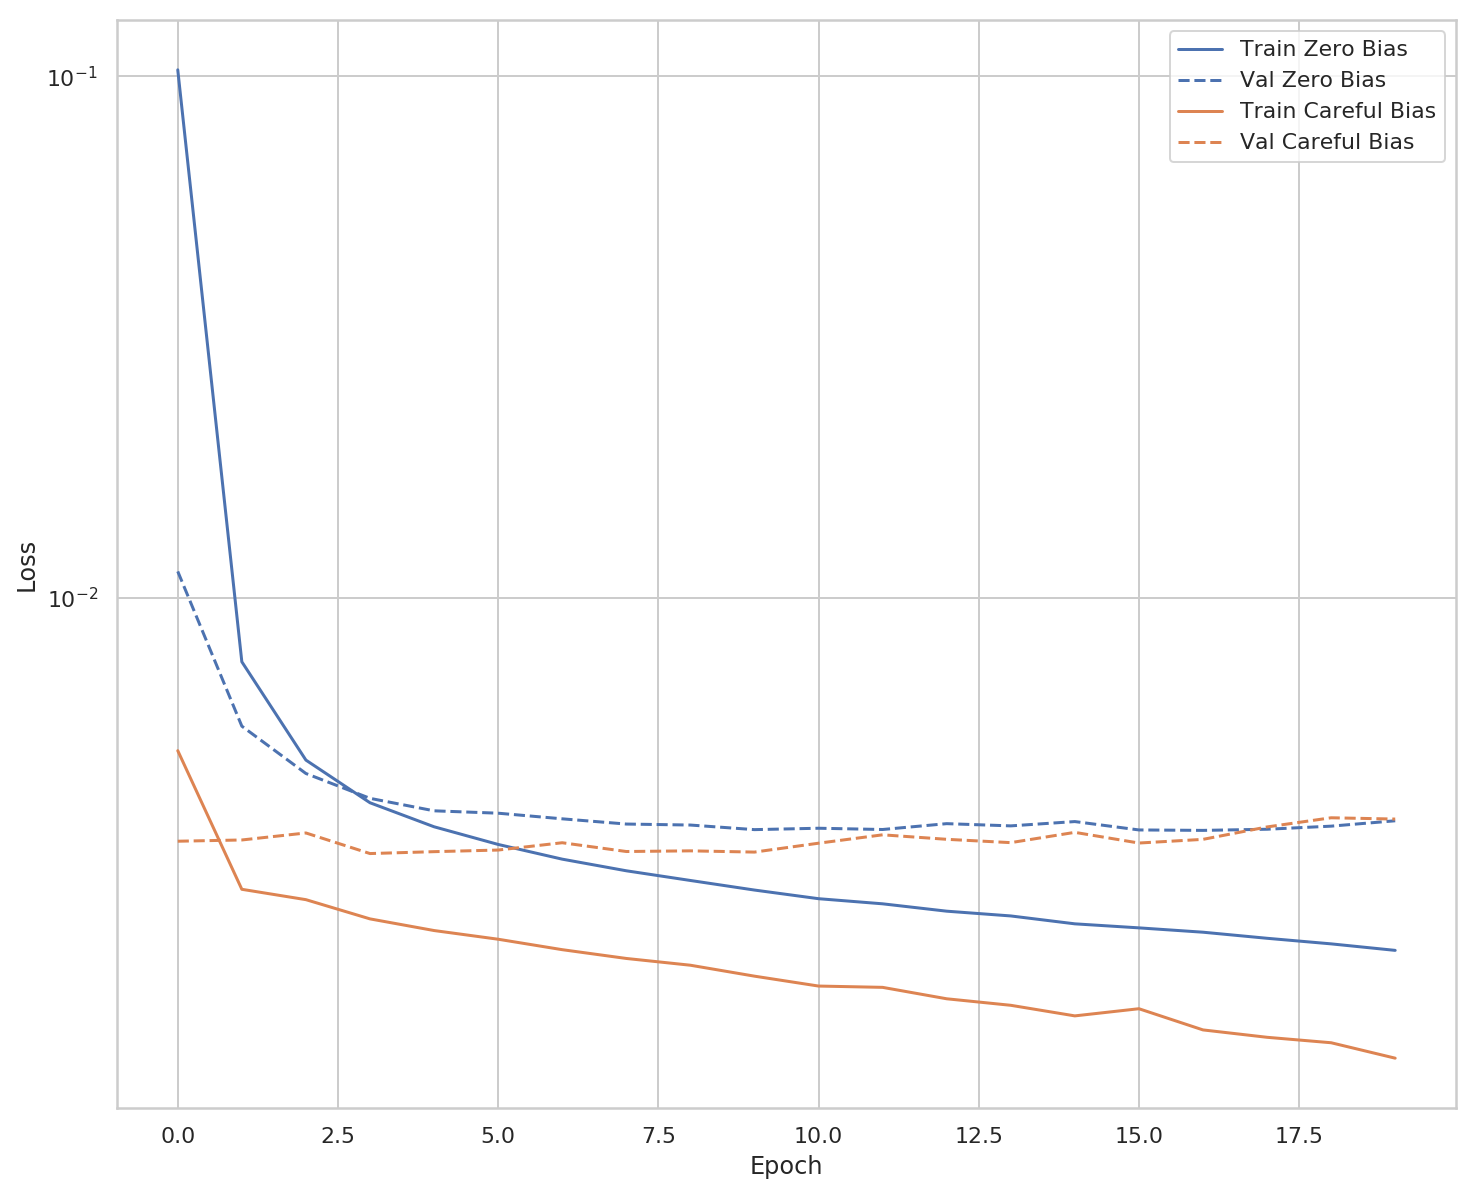

In [120]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias",1)

In [0]:
NAME = "baseline_model"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs",NAME))

In [122]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels, 
    batch_size=512,
    epochs=30,
    callbacks=[early_stopping, tensorboard],
    validation_data=(val_features,val_labels)
)

Train on 227845 samples, validate on 56962 samples
Epoch 1/30
227845/227845 [==============================] - 5s 22us/sample - loss: 0.0037 - tp: 269.0000 - fp: 30.0000 - tn: 227424.0000 - fn: 122.0000 - accuracy: 0.9993 - precision: 0.8997 - recall: 0.6880 - auc: 0.9233 - val_loss: 0.0034 - val_tp: 77.0000 - val_fp: 11.0000 - val_tn: 56850.0000 - val_fn: 24.0000 - val_accuracy: 0.9994 - val_precision: 0.8750 - val_recall: 0.7624 - val_auc: 0.9203
Epoch 2/30
227845/227845 [==============================] - 3s 12us/sample - loss: 0.0026 - tp: 298.0000 - fp: 37.0000 - tn: 227417.0000 - fn: 93.0000 - accuracy: 0.9994 - precision: 0.8896 - recall: 0.7621 - auc: 0.9458 - val_loss: 0.0033 - val_tp: 77.0000 - val_fp: 15.0000 - val_tn: 56846.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8370 - val_recall: 0.7624 - val_auc: 0.9202
Epoch 3/30
227845/227845 [==============================] - 3s 12us/sample - loss: 0.0024 - tp: 310.0000 - fp: 32.0000 - tn: 227422.0000 - fn: 81.

In [0]:
def plot_metrics(history):
    metrics = ["loss", "auc", "precision", "recall"]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0],label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--",label="Val")
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "auc":
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0,1])
        plt.tight_layout()
        plt.legend()

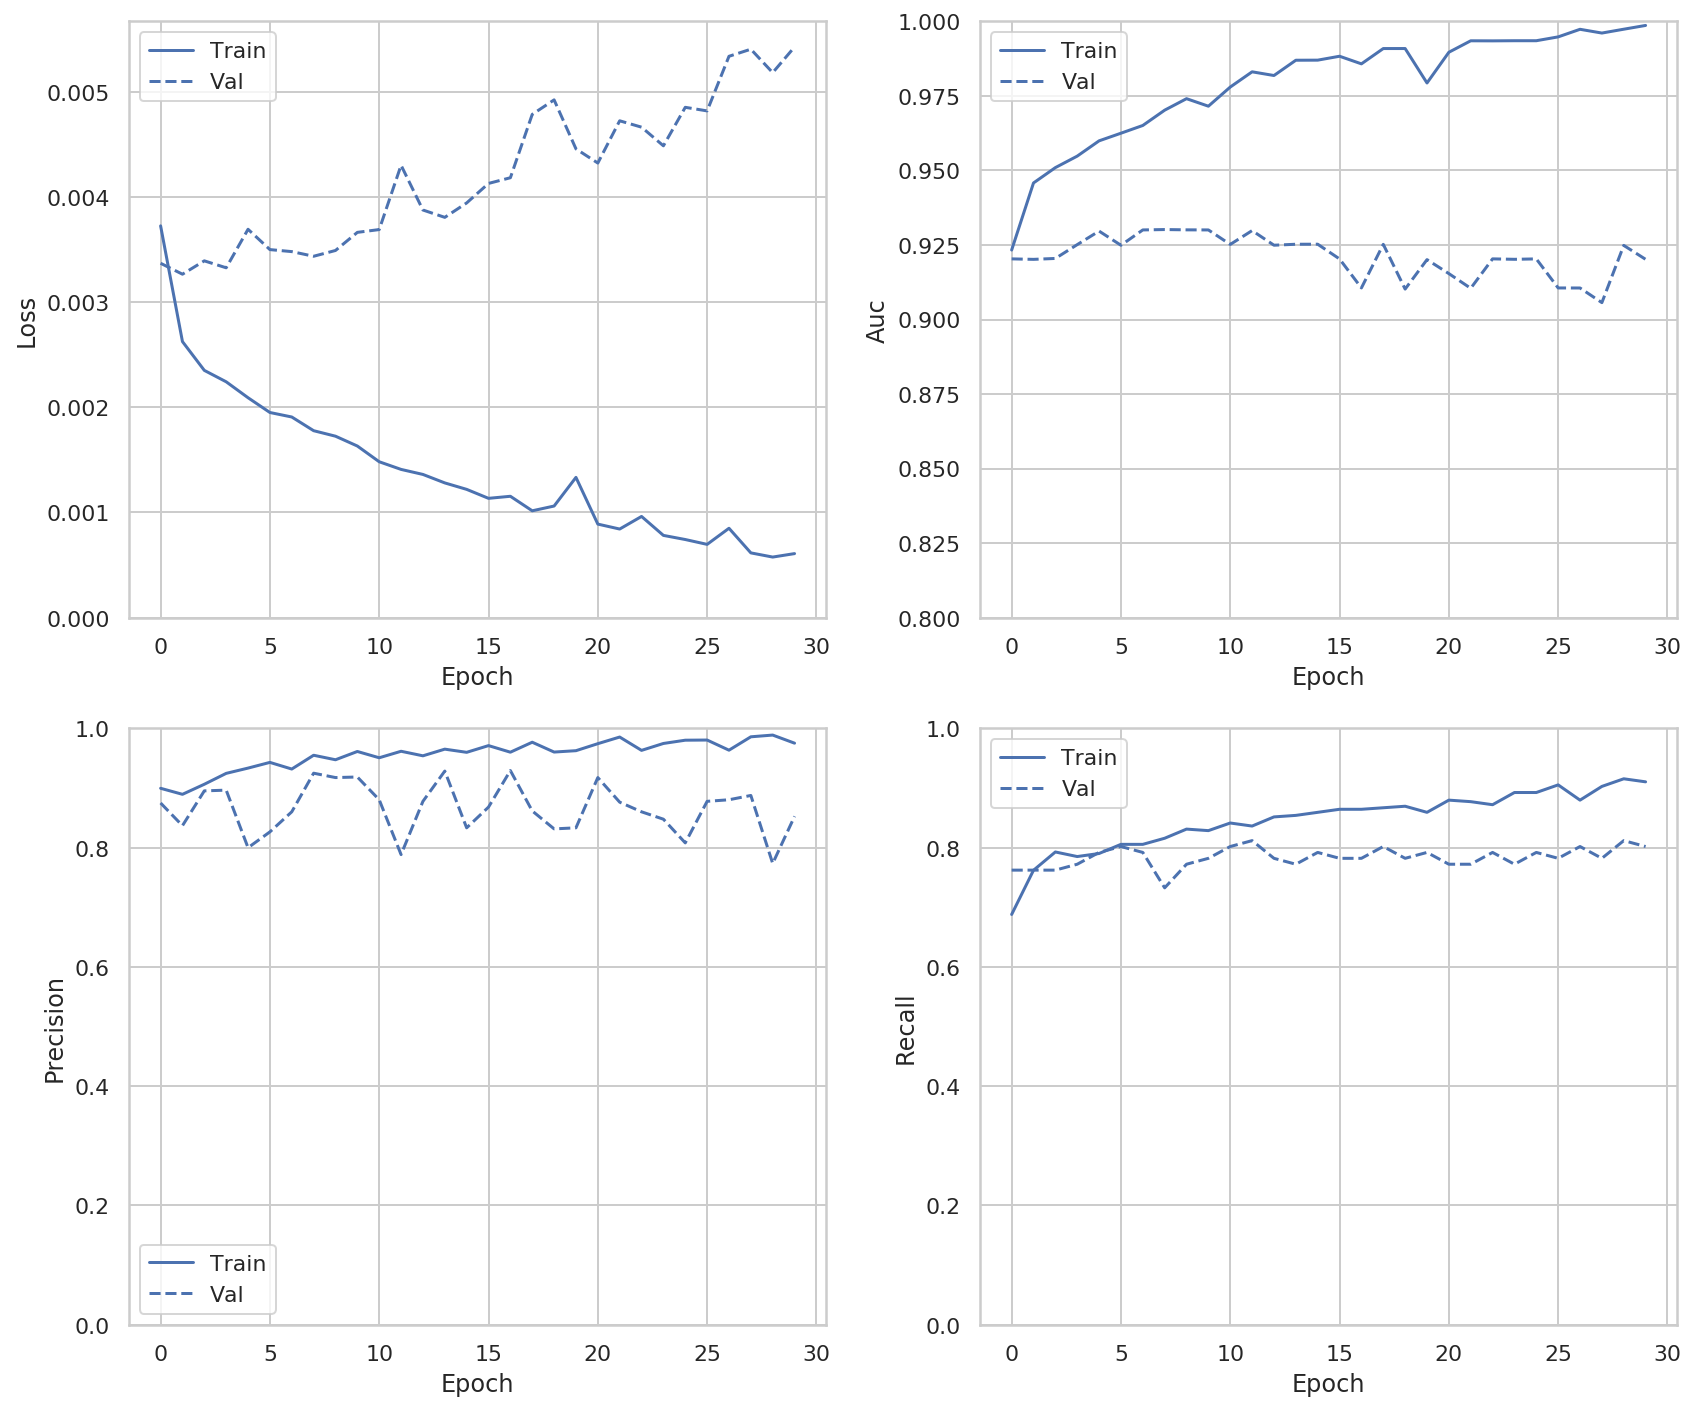

In [124]:
plot_metrics(baseline_history)

In [0]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [0]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions>0.5)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, center=0, linewidths=1, cmap="RdBu", fmt="d")
    plt.title("Confusion matrix @{:.2f}".format(p))
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

    print("Legitimate Transactions Detected (True Negatives): ",cm[0][0])
    print("Legitimate Transactions Incorrectly Detected (False Positives): ",cm[0][1])
    print("Legitimate Transactions Missed (False Negatives): ",cm[1][0])
    print("Legitimate Transactions Detected (True Positives): ",cm[1][1])
    print("Total Fradulent Transactions: ", np.sum(cm[1]))

In [0]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

In [128]:
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ":", value)
print()

loss : 0.0014040468319203006
tp : 79.0
fp : 7.0
tn : 56868.0
fn : 8.0
accuracy : 0.99973667
precision : 0.9186047
recall : 0.90804595
auc : 0.97107506



Legitimate Transactions Detected (True Negatives):  56868
Legitimate Transactions Incorrectly Detected (False Positives):  7
Legitimate Transactions Missed (False Negatives):  8
Legitimate Transactions Detected (True Positives):  79
Total Fradulent Transactions:  87


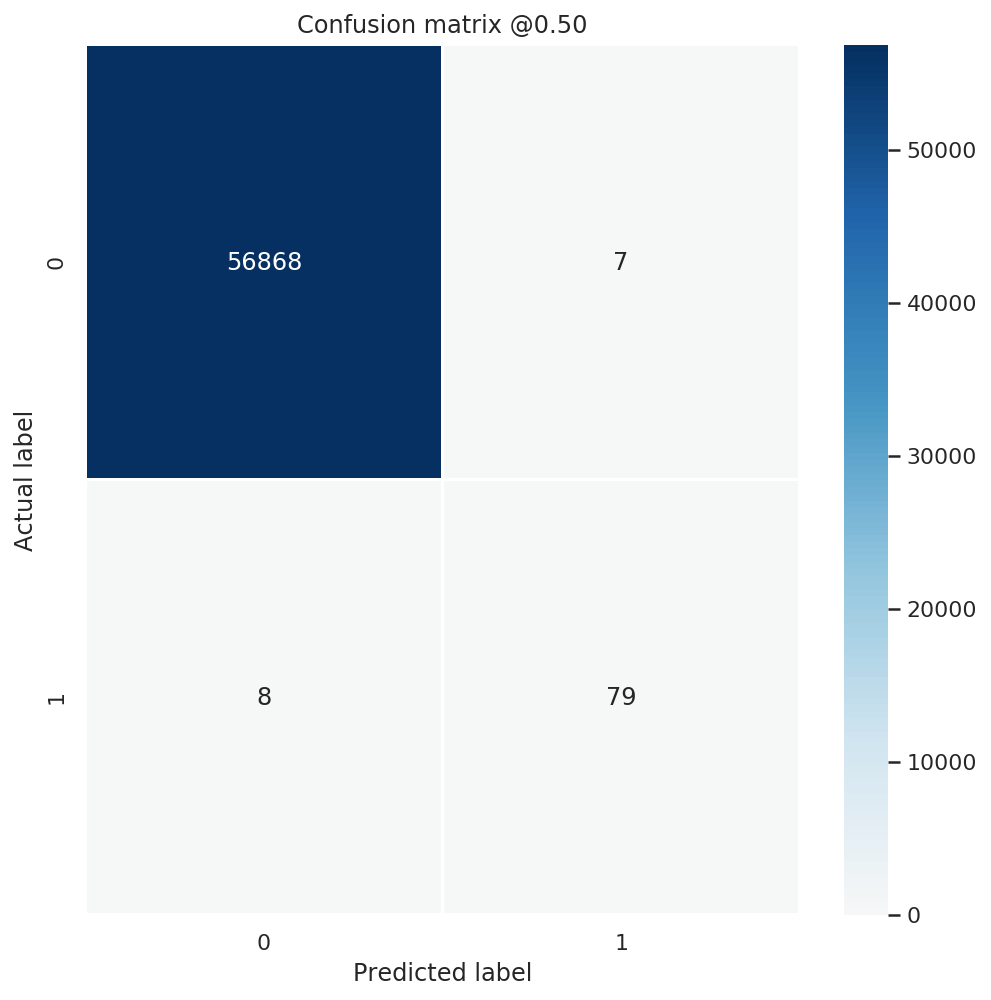

In [129]:
plot_cm(test_labels, test_predictions_baseline)

In [0]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel("False Positives [%]")
    plt.ylabel("True Positives [%]")
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect("equal")

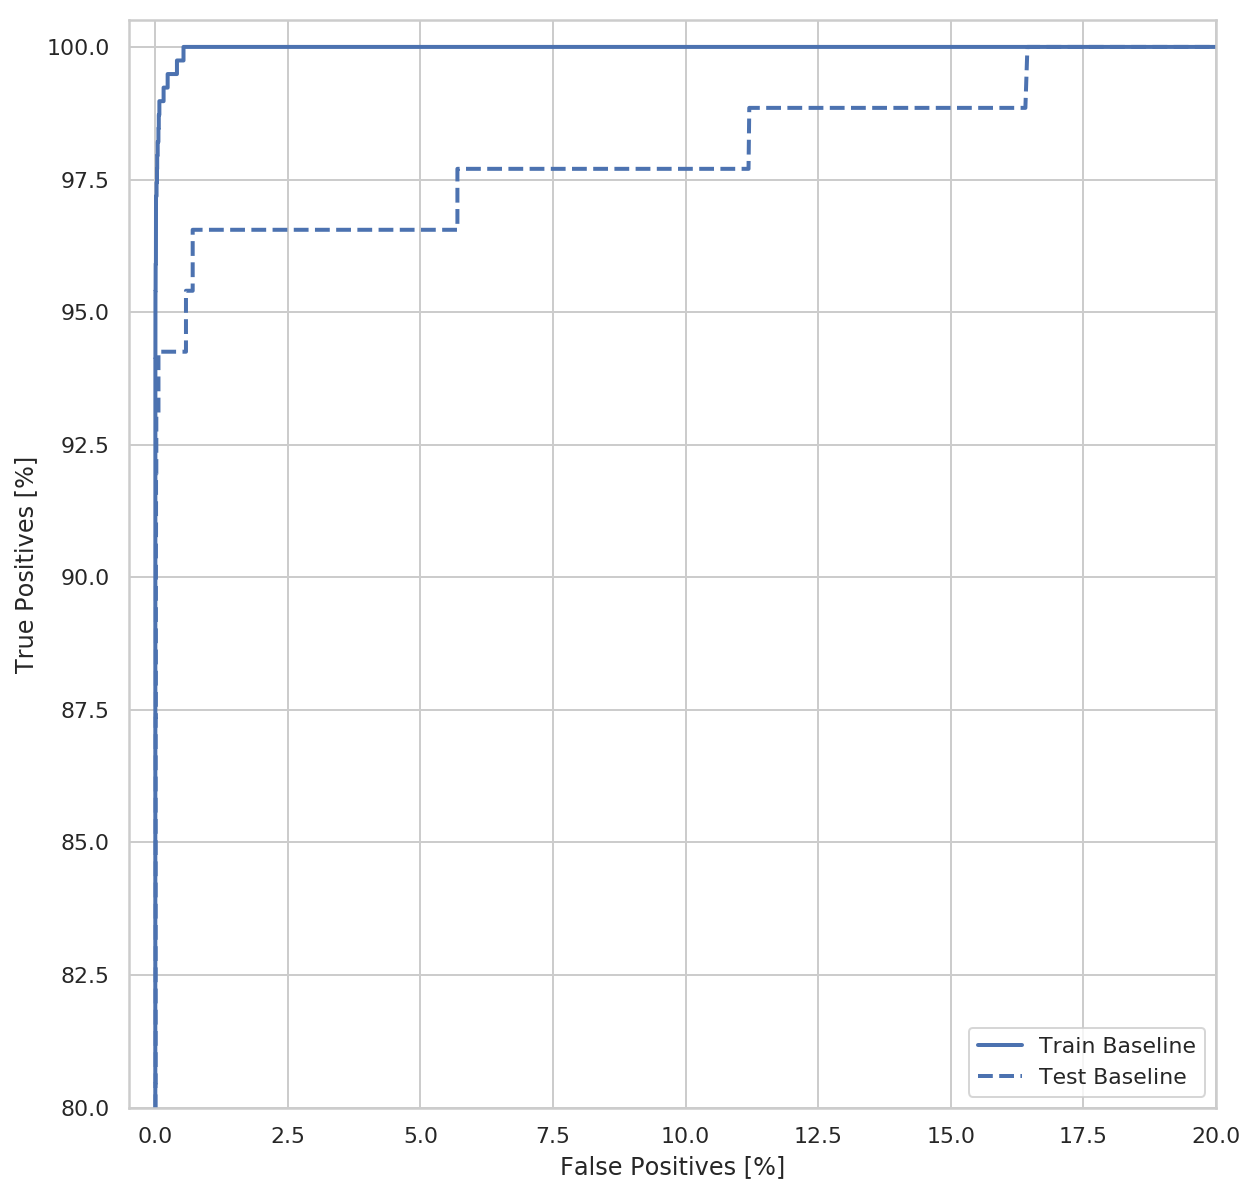

In [131]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle="--")
plt.legend(loc="lower right")

### Class Weights

In [132]:
weight_for_0 = (1/neg)*(total)/2.0
weight_for_1 = (1/pos)*(total)/2.0

class_weight = {0:weight_for_0,1:weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [133]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=30,
    callbacks=[early_stopping],
    validation_data=((val_features, val_labels)),
    class_weight = class_weight
)

Train on 227845 samples, validate on 56962 samples
Epoch 1/30
227845/227845 [==============================] - 5s 21us/sample - loss: 0.6678 - tp: 275.0000 - fp: 2356.0000 - tn: 225098.0000 - fn: 116.0000 - accuracy: 0.9892 - precision: 0.1045 - recall: 0.7033 - auc: 0.8989 - val_loss: 0.2703 - val_tp: 86.0000 - val_fp: 1502.0000 - val_tn: 55359.0000 - val_fn: 15.0000 - val_accuracy: 0.9734 - val_precision: 0.0542 - val_recall: 0.8515 - val_auc: 0.9615
Epoch 2/30
227845/227845 [==============================] - 2s 7us/sample - loss: 0.1581 - tp: 355.0000 - fp: 6874.0000 - tn: 220580.0000 - fn: 36.0000 - accuracy: 0.9697 - precision: 0.0491 - recall: 0.9079 - auc: 0.9836 - val_loss: 0.2495 - val_tp: 87.0000 - val_fp: 1878.0000 - val_tn: 54983.0000 - val_fn: 14.0000 - val_accuracy: 0.9668 - val_precision: 0.0443 - val_recall: 0.8614 - val_auc: 0.9609
Epoch 3/30
227845/227845 [==============================] - 2s 7us/sample - loss: 0.1389 - tp: 358.0000 - fp: 6855.0000 - tn: 220599.0000 -

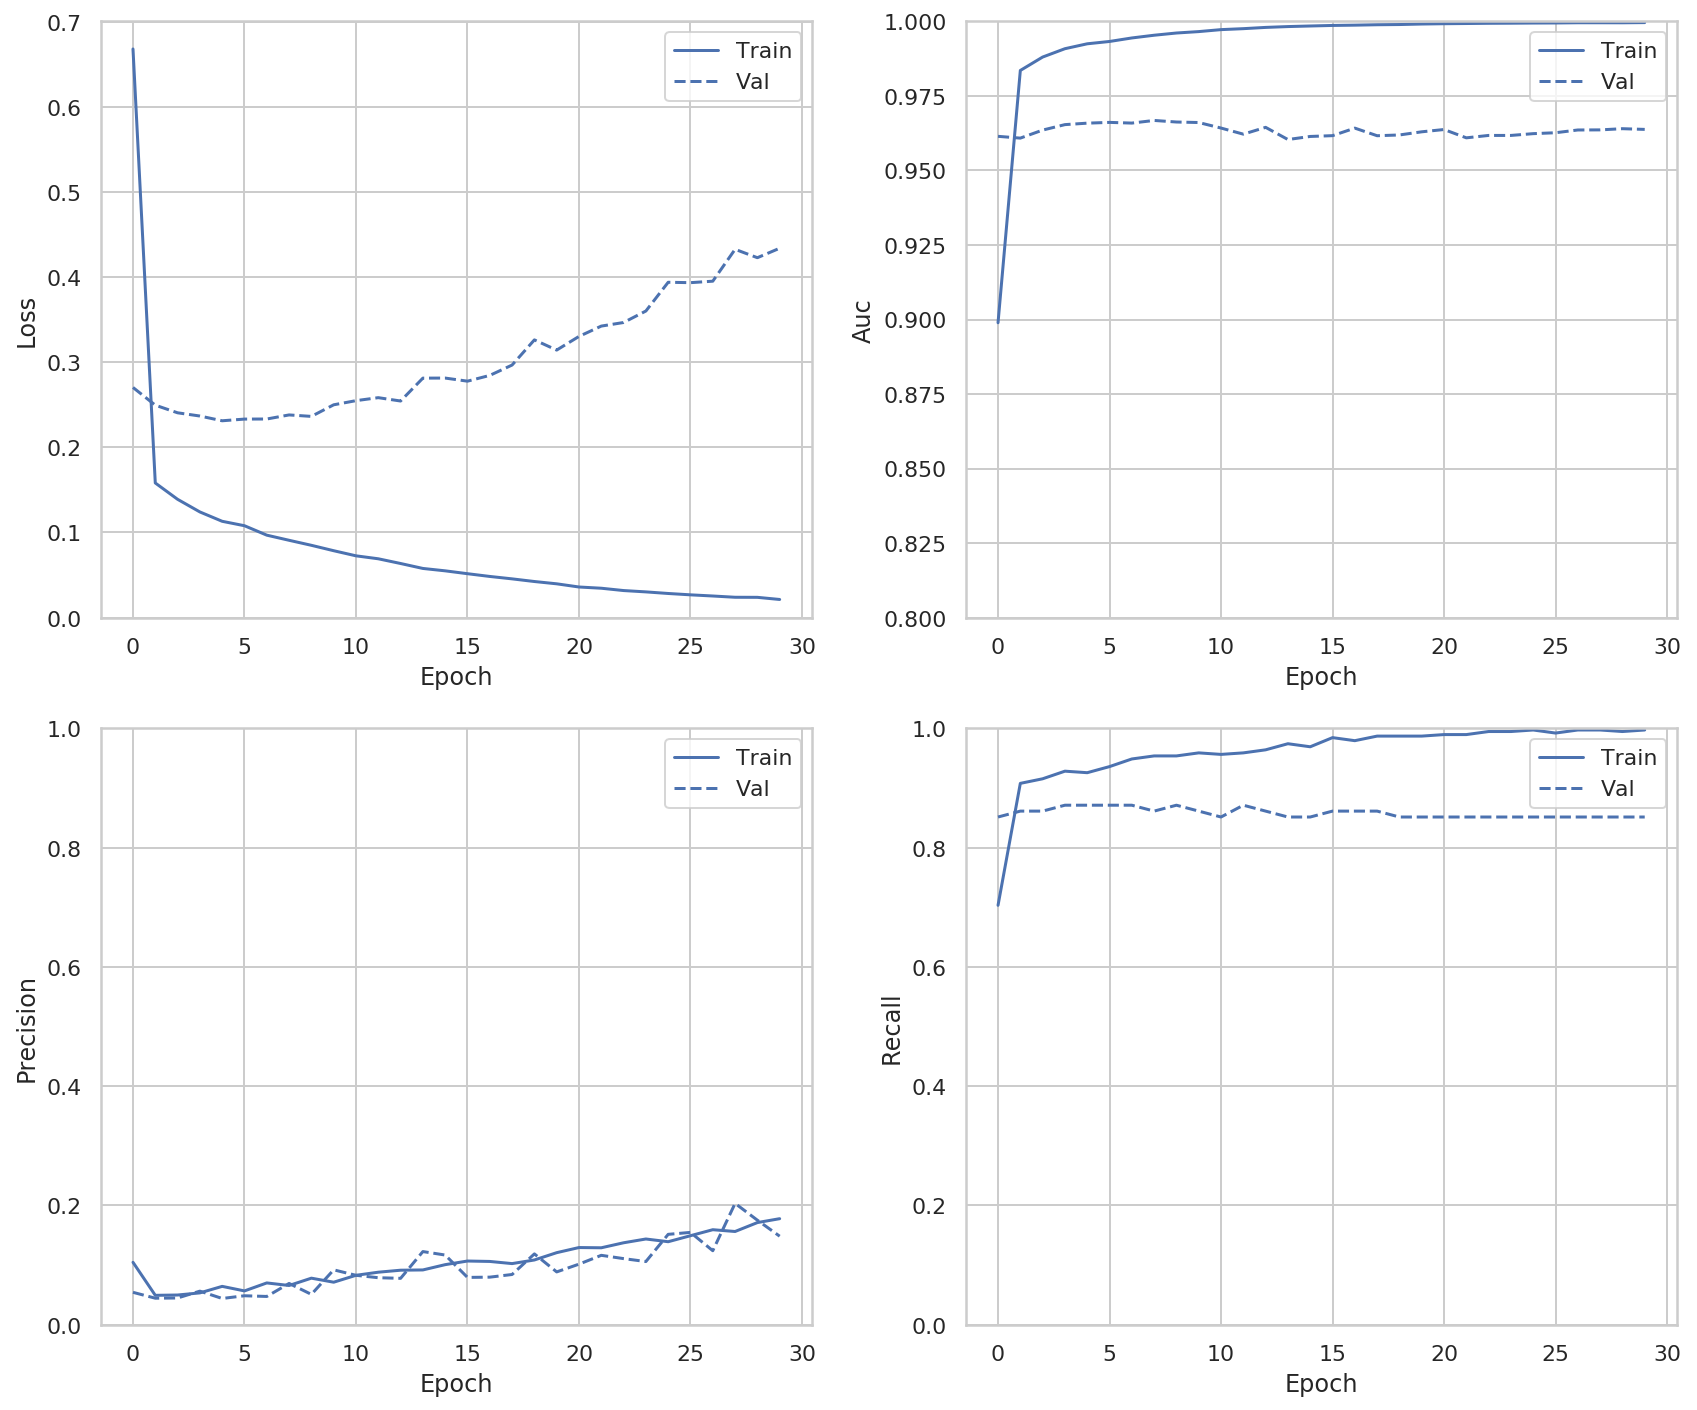

In [134]:
plot_metrics(weighted_history)

In [0]:
train_predictions_weighted = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = model.predict(test_features, batch_size=BATCH_SIZE)

loss : 0.0014040468319203006
tp : 79.0
fp : 7.0
tn : 56868.0
fn : 8.0
accuracy : 0.99973667
precision : 0.9186047
recall : 0.90804595
auc : 0.97107506

Legitimate Transactions Detected (True Negatives):  56868
Legitimate Transactions Incorrectly Detected (False Positives):  7
Legitimate Transactions Missed (False Negatives):  8
Legitimate Transactions Detected (True Positives):  79
Total Fradulent Transactions:  87


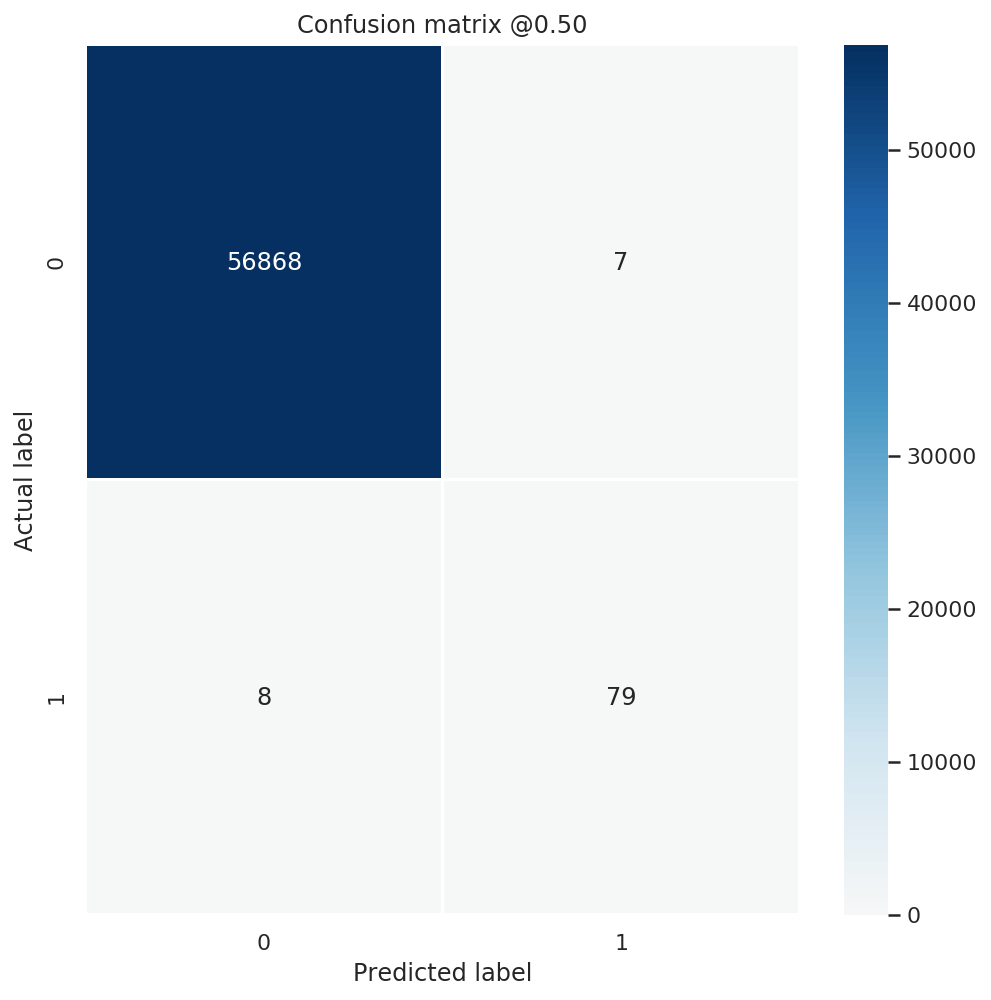

In [136]:
weighted_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE,verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ":", value)
print()

plot_cm(test_labels, test_predictions_weighted)

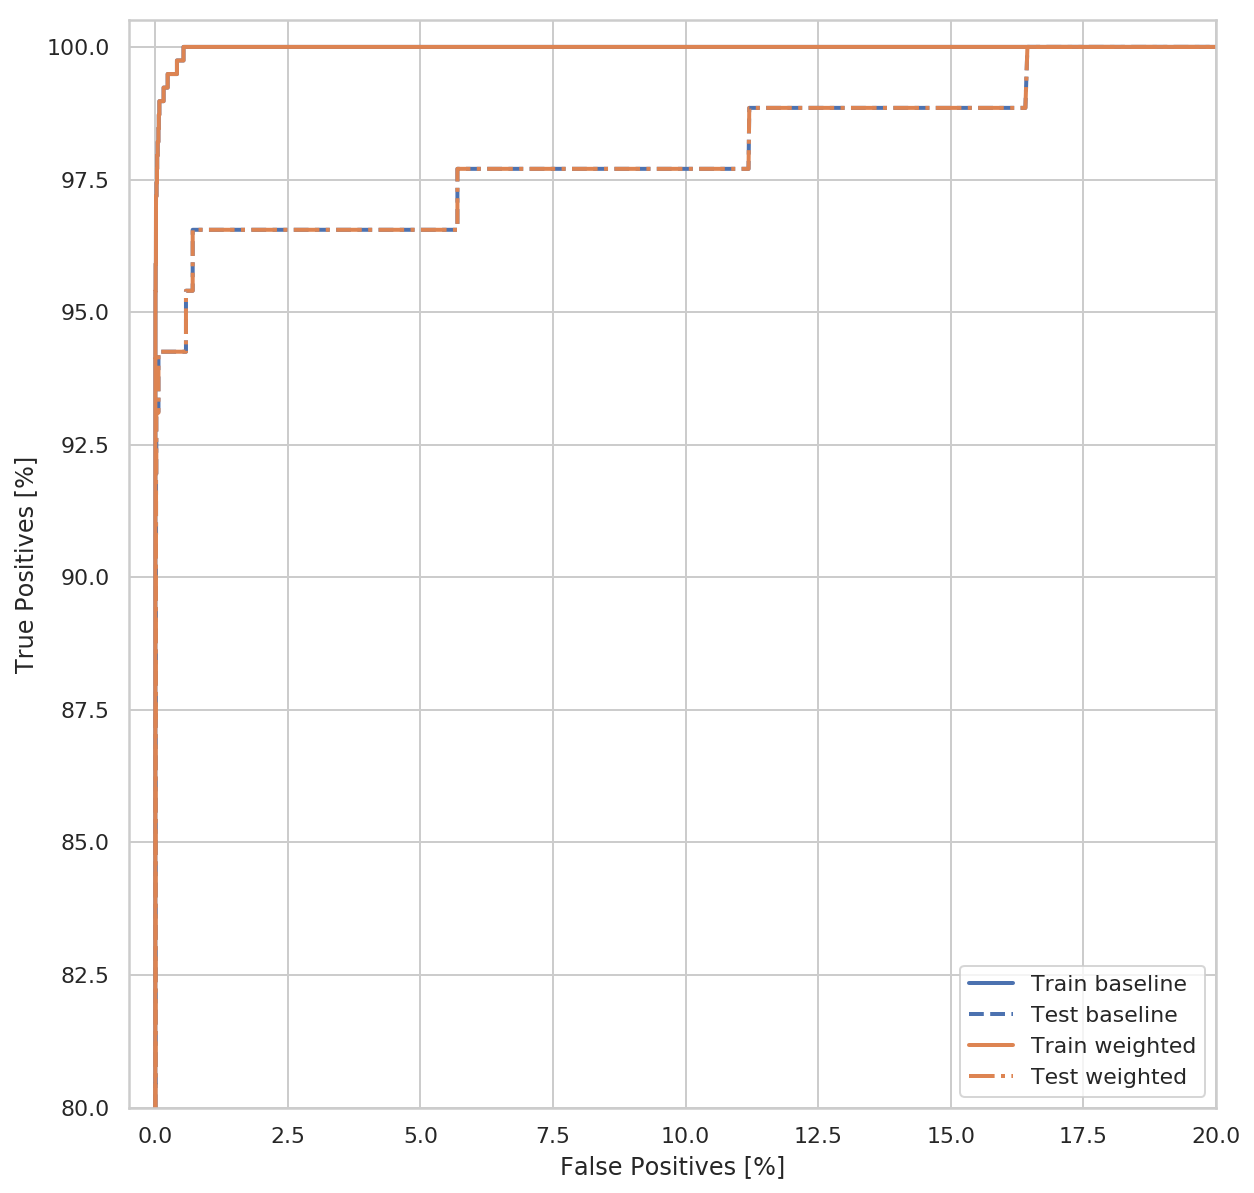

In [137]:
plot_roc("Train baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle="--")

plot_roc("Train weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle="-.")

plt.legend(loc="lower right")

### Oversampling

In [0]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [139]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(227454, 29)

In [140]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

print(resampled_features.shape)
print(resampled_labels.shape)

(454908, 29)
(454908,)


#### tf.data

In [0]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [142]:
for features, labels in pos_ds.take(1):
    print(f"\nFeatures {features.numpy()}")
    print()
    print(f"\nLabel {labels.numpy()}")


Features [-2.02 -0.75 -2.44  3.21  2.92 -2.55 -4.06  0.84 -2.9  -3.9   4.1  -4.57
  1.19 -5.    1.22 -5.   -5.   -1.41  4.38  2.7   1.44 -0.05  0.55 -0.27
  0.79 -0.25  2.15  2.01 -0.41]


Label 1


In [0]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5,0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [144]:
for features, labels in resampled_ds.take(1):
    print(labels.numpy().mean())

0.5048828125


In [145]:
reasmpled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
reasmpled_steps_per_epoch

278.0

In [146]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=40,
    steps_per_epoch=reasmpled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data = val_ds
)

Train for 278.0 steps, validate for 28 steps
Epoch 1/40
278/278 [==============================] - 13s 46ms/step - loss: 0.1804 - tp: 262980.0000 - fp: 17637.0000 - tn: 266427.0000 - fn: 22300.0000 - accuracy: 0.9299 - precision: 0.9371 - recall: 0.9218 - auc: 0.9776 - val_loss: 0.0680 - val_tp: 87.0000 - val_fp: 923.0000 - val_tn: 55938.0000 - val_fn: 14.0000 - val_accuracy: 0.9836 - val_precision: 0.0861 - val_recall: 0.8614 - val_auc: 0.9601
Epoch 2/40
278/278 [==============================] - 11s 38ms/step - loss: 0.0520 - tp: 277563.0000 - fp: 3810.0000 - tn: 281001.0000 - fn: 6970.0000 - accuracy: 0.9811 - precision: 0.9865 - recall: 0.9755 - auc: 0.9987 - val_loss: 0.0401 - val_tp: 86.0000 - val_fp: 600.0000 - val_tn: 56261.0000 - val_fn: 15.0000 - val_accuracy: 0.9892 - val_precision: 0.1254 - val_recall: 0.8515 - val_auc: 0.9623
Epoch 3/40
278/278 [==============================] - 10s 38ms/step - loss: 0.0271 - tp: 284179.0000 - fp: 2553.0000 - tn: 281769.0000 - fn: 843.0000

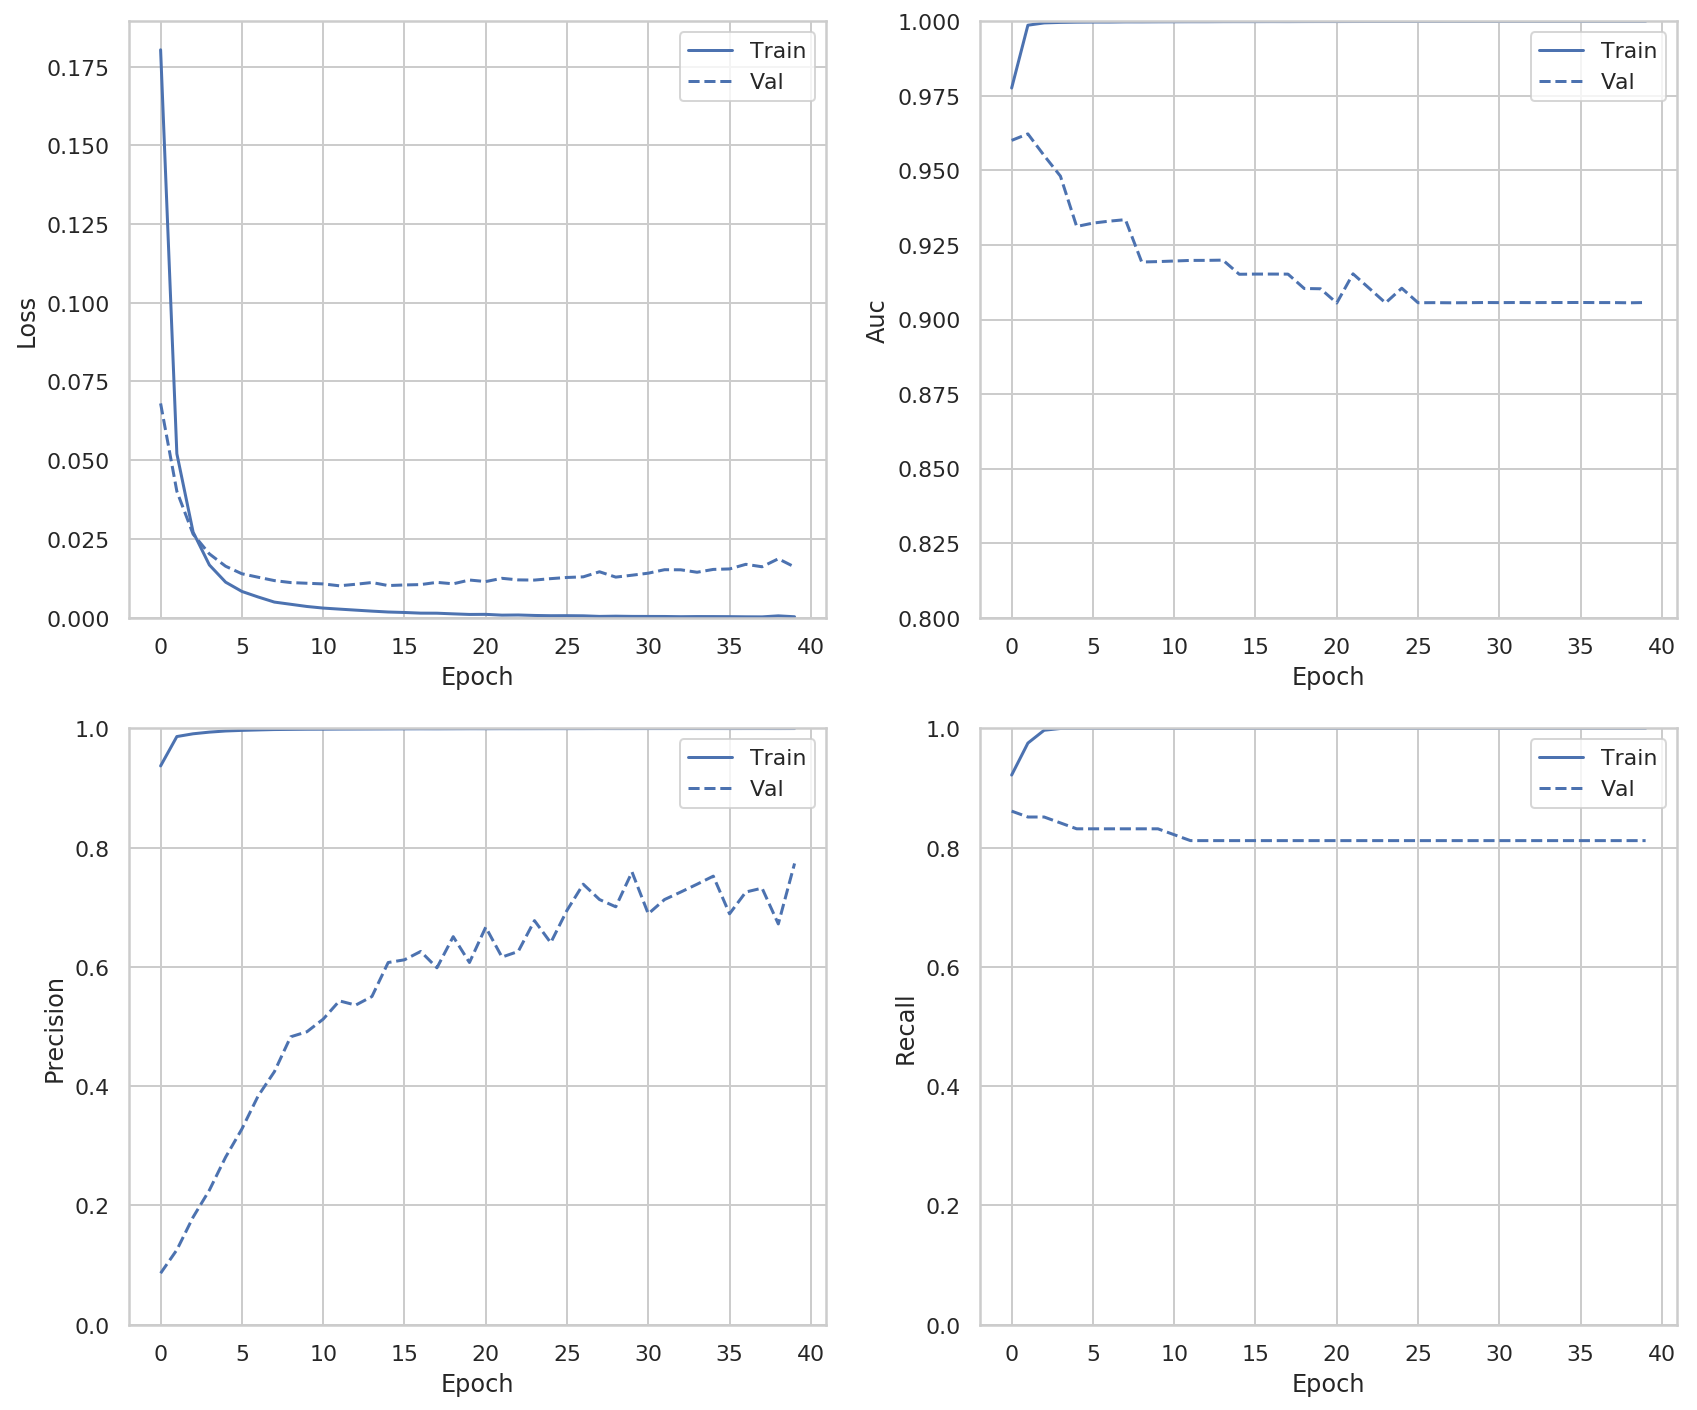

In [147]:
plot_metrics(resampled_history)

#### Re-train

In [148]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds, 
    steps_per_epoch=20,
    epochs = 30,
    callbacks=[early_stopping],
    validation_data=(val_ds) 
)

Train for 20 steps, validate for 28 steps
Epoch 1/30
20/20 [==============================] - 4s 210ms/step - loss: 0.8122 - tp: 15097.0000 - fp: 8882.0000 - tn: 11437.0000 - fn: 5544.0000 - accuracy: 0.6478 - precision: 0.6296 - recall: 0.7314 - auc: 0.7278 - val_loss: 0.5638 - val_tp: 94.0000 - val_fp: 15140.0000 - val_tn: 41721.0000 - val_fn: 7.0000 - val_accuracy: 0.7341 - val_precision: 0.0062 - val_recall: 0.9307 - val_auc: 0.9563
Epoch 2/30
20/20 [==============================] - 1s 50ms/step - loss: 0.2716 - tp: 19001.0000 - fp: 2718.0000 - tn: 17802.0000 - fn: 1439.0000 - accuracy: 0.8985 - precision: 0.8749 - recall: 0.9296 - auc: 0.9635 - val_loss: 0.2793 - val_tp: 90.0000 - val_fp: 3180.0000 - val_tn: 53681.0000 - val_fn: 11.0000 - val_accuracy: 0.9440 - val_precision: 0.0275 - val_recall: 0.8911 - val_auc: 0.9594
Epoch 3/30
20/20 [==============================] - 1s 52ms/step - loss: 0.2033 - tp: 18694.0000 - fp: 867.0000 - tn: 19535.0000 - fn: 1864.0000 - accuracy: 0.93

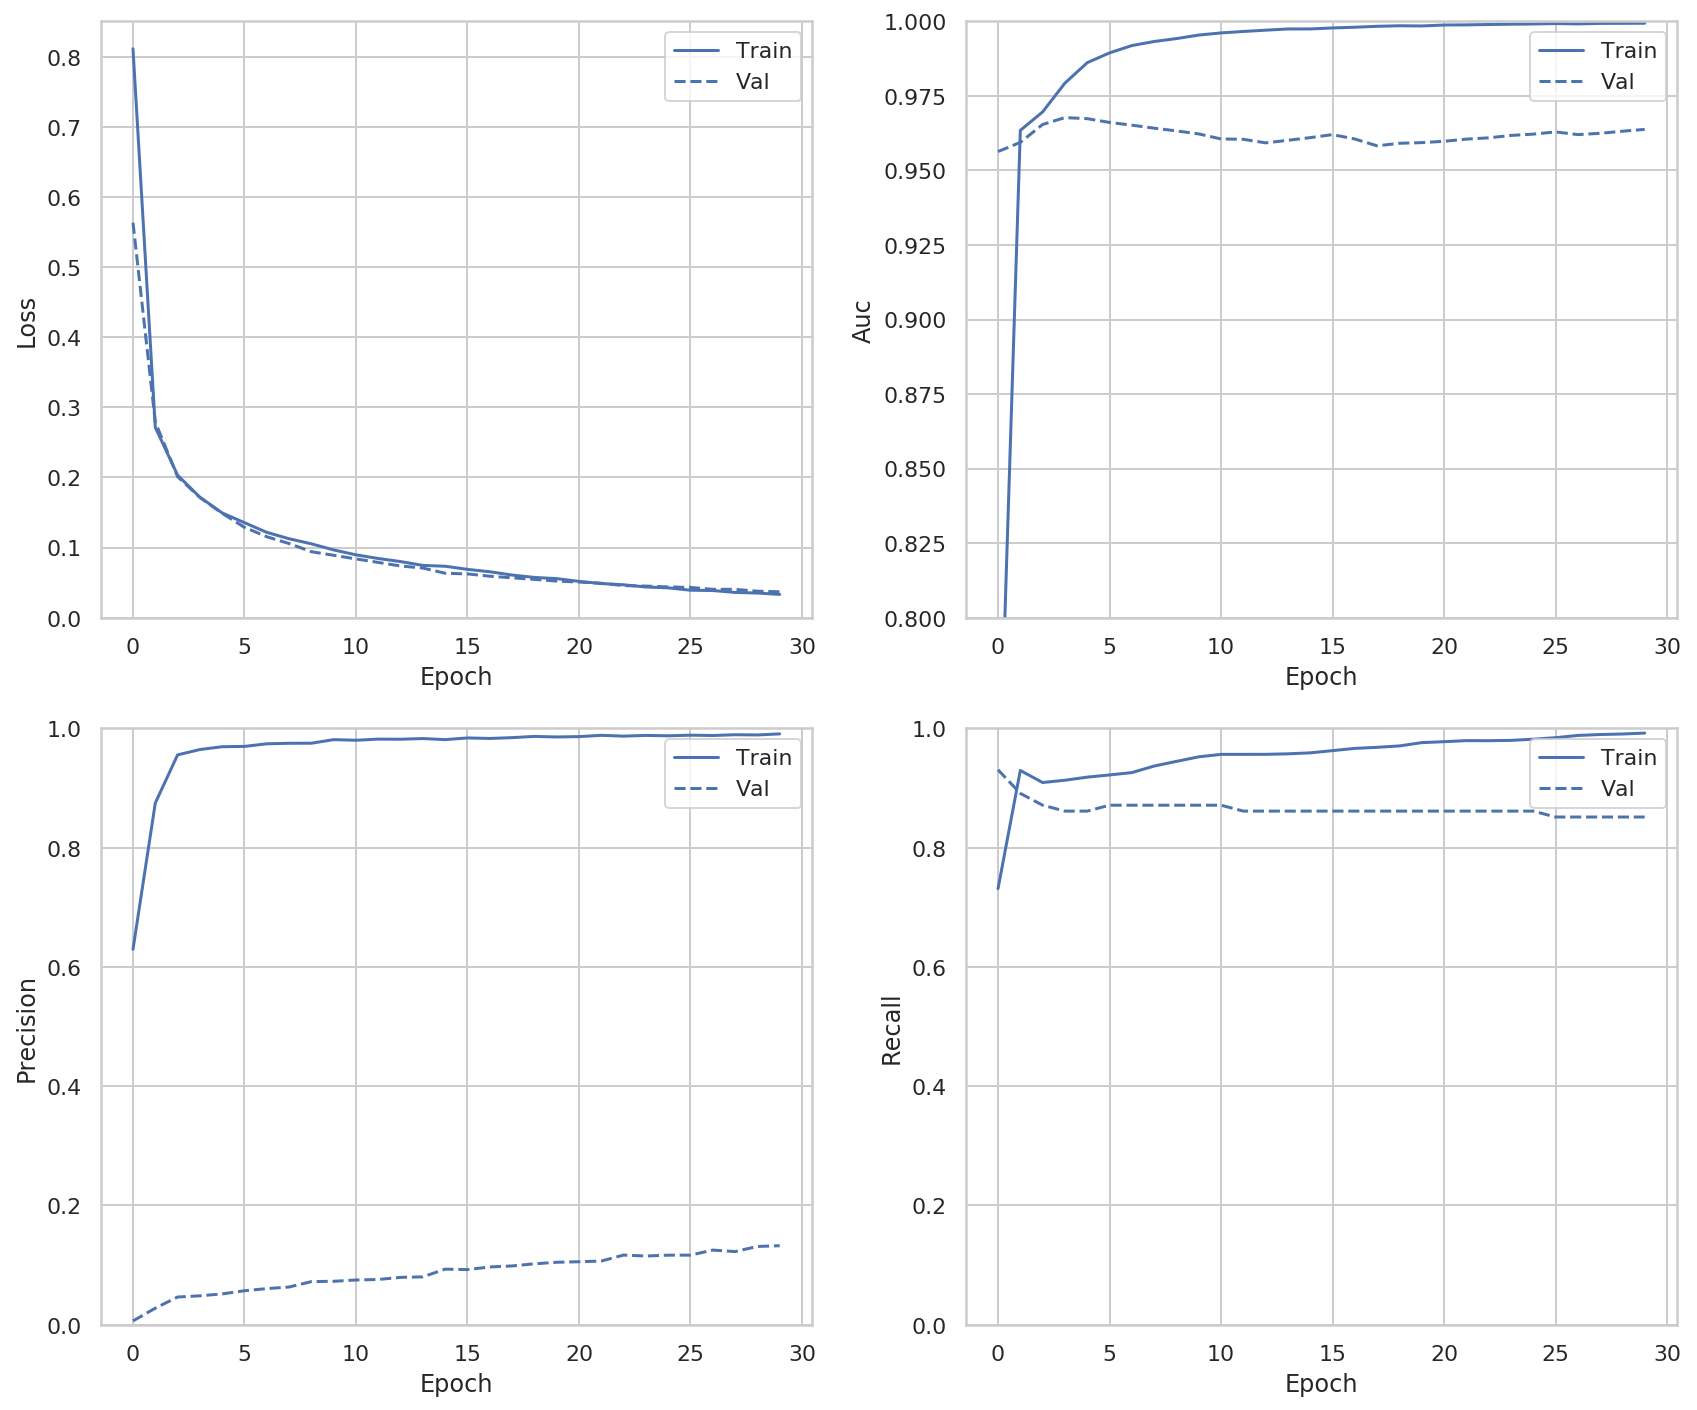

In [149]:
plot_metrics(resampled_history)

In [0]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

In [0]:
resampled_results = resampled_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE,verbose=0)

loss : 0.0014040468319203006
tp : 79.0
fp : 7.0
tn : 56868.0
fn : 8.0
accuracy : 0.99973667
precision : 0.9186047
recall : 0.90804595
auc : 0.97107506

Legitimate Transactions Detected (True Negatives):  56311
Legitimate Transactions Incorrectly Detected (False Positives):  564
Legitimate Transactions Missed (False Negatives):  5
Legitimate Transactions Detected (True Positives):  82
Total Fradulent Transactions:  87


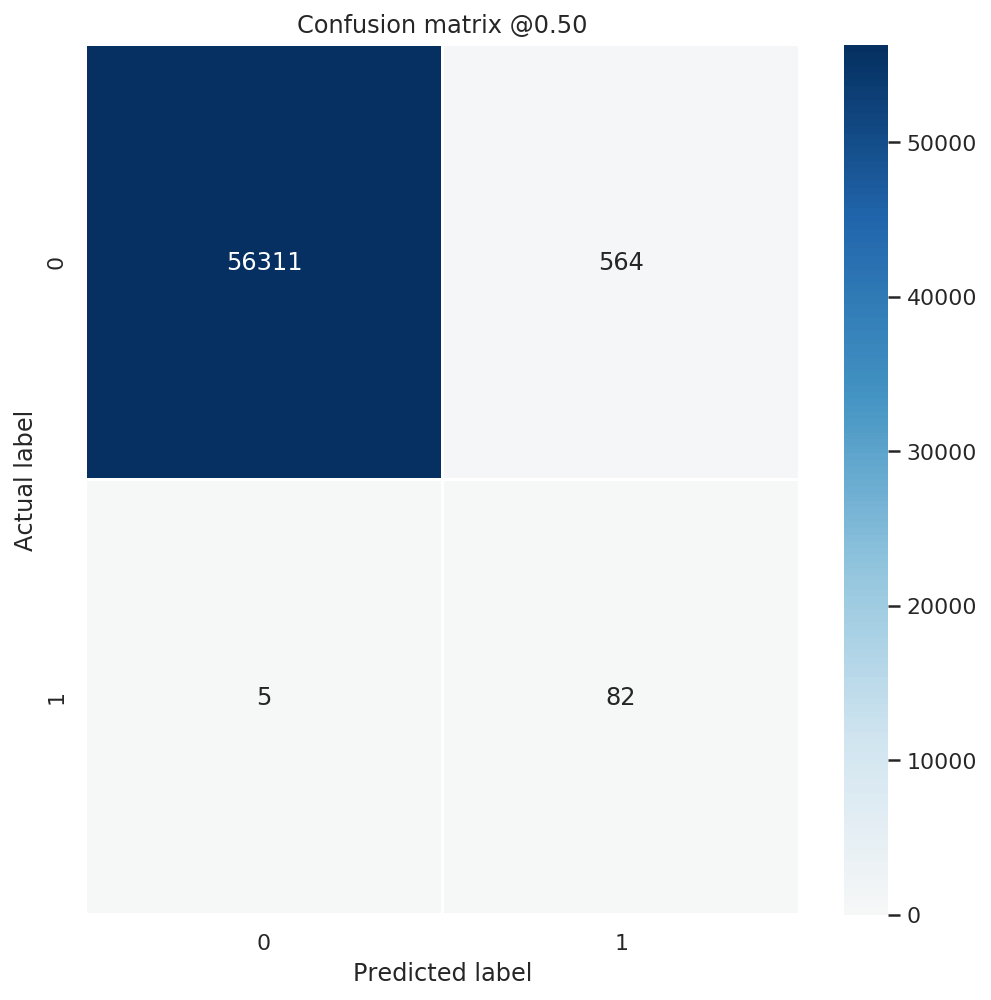

In [152]:
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ":", value)
print()

plot_cm(test_labels, test_predictions_resampled)

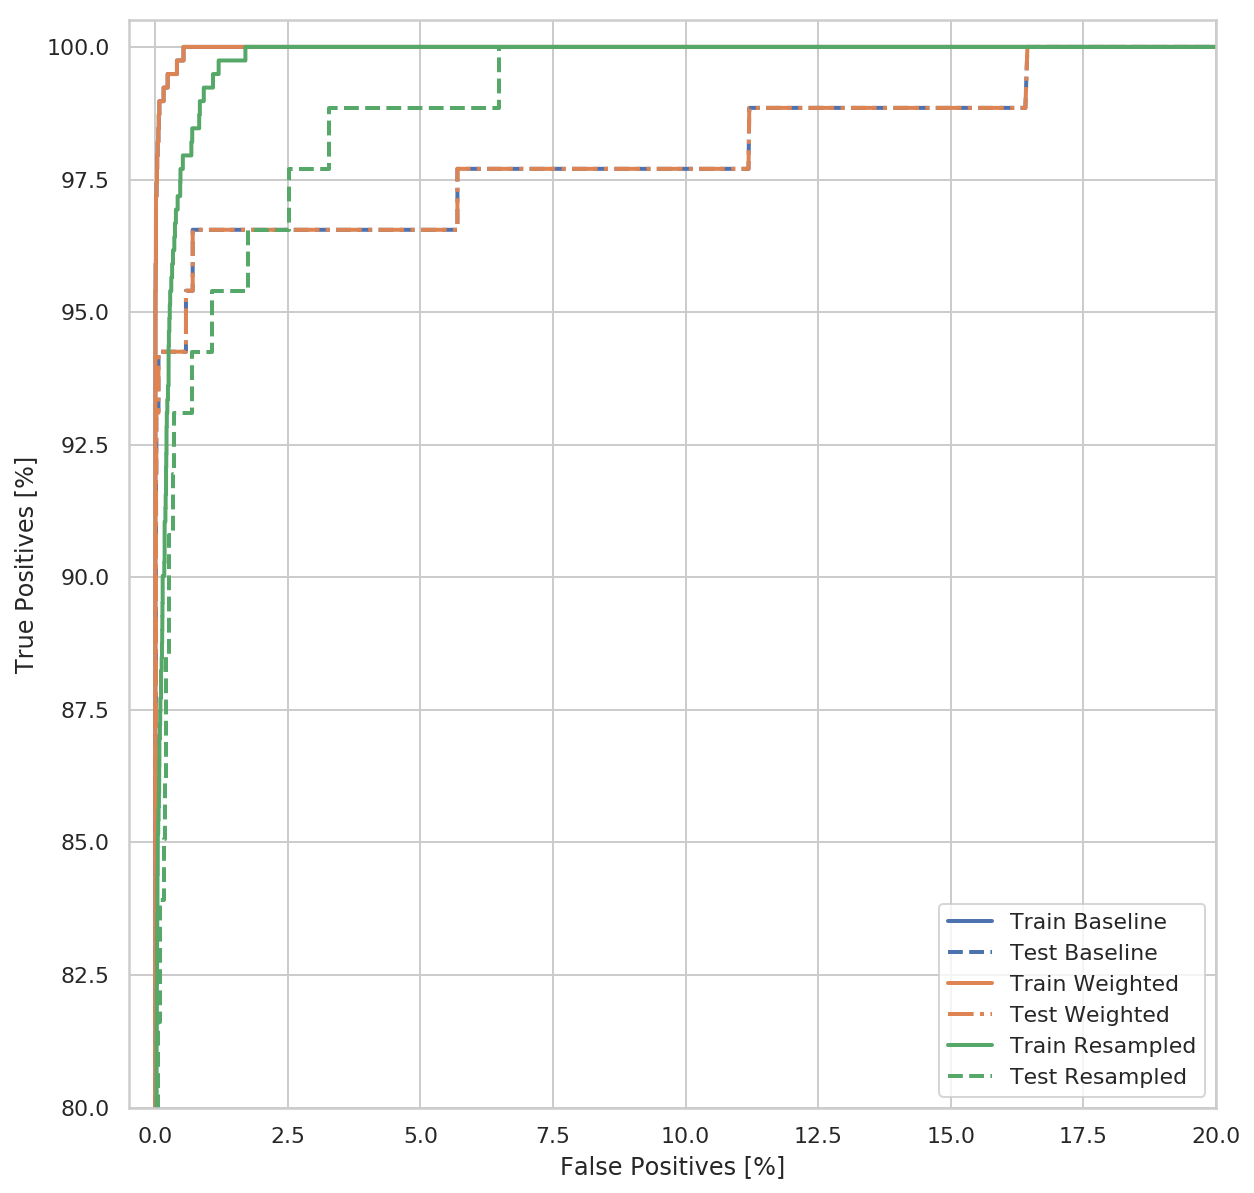

In [161]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline,color=colors[0],linestyle="--")

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted,color=colors[1],linestyle="-.")

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,color=colors[2],linestyle="--")

plt.legend()